In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import itertools
import logging
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler
from sklearn.neighbors import NearestNeighbors

from nf.flows import *
from nf.models import NormalizingFlowModel
import matplotlib.pyplot as plt

In [3]:
! ls ../data/data_calibsample

kaon2_+_down_2016_.csv	muon_+_down_2016_.csv	pion_+_down_2016_.csv
kaon2_+_up_2016_.csv	muon_+_up_2016_.csv	pion_+_up_2016_.csv
kaon2_-_down_2016_.csv	muon_-_down_2016_.csv	pion_-_down_2016_.csv
kaon2_-_up_2016_.csv	muon_-_up_2016_.csv	pion_-_up_2016_.csv
kaon_+_down_2016_.csv	pion2_+_down_2016_.csv	proton_+_down_2016_.csv
kaon_+_up_2016_.csv	pion2_+_up_2016_.csv	proton_+_up_2016_.csv
kaon_-_down_2016_.csv	pion2_-_down_2016_.csv	proton_-_down_2016_.csv
kaon_-_up_2016_.csv	pion2_-_up_2016_.csv	proton_-_up_2016_.csv


In [4]:
device = 'cuda'
batch_size = 8192
data_dir = '../data/data_calibsample'
particle = 'muon'
weight_filed = 'probe_sWeight'
features = ['Brunel_P', 'Brunel_ETA', 'nTracks_Brunel']
dlls = ['RichDLLp', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLbt']
fields = [weight_filed] + features + dlls

In [5]:
data = pd.concat([
    pd.read_csv(os.path.join(data_dir, f), sep='\t')[fields]
    for f in os.listdir(data_dir) if particle in f
]).sample(frac=1)
data.head()

,probe_sWeight,Brunel_P,Brunel_ETA,nTracks_Brunel,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt
48951,0.820805,8238.0,2.77410,160,-25.744300,-13.659700,7.153340,-25.744300,-25.744300
35778,1.218870,12902.7,3.11149,153,33.438000,-4.386670,-3.288950,22.121100,33.438000
327717,-0.179056,11542.8,4.73217,464,-2.004020,0.439280,0.764677,-2.004020,-2.004020
324641,1.069680,14683.5,2.98675,148,-33.353400,3.895670,5.683960,-42.504700,-33.353400
256456,0.325032,24316.9,4.69128,230,-0.283602,-0.601832,0.382646,-0.526871,-0.283602


In [6]:
data = data[data.RichDLLe > -998]
data = data[data.RichDLLp != 0.0]
data.shape

(1984209, 9)

In [7]:
X, Y, weights = data[features].values.astype(np.float32), data[dlls].values.astype(np.float32), data[weight_filed].values.astype(np.float32)
train_size = data.shape[0] * 7 // 10

X_train_, Y_train_, w_train = X[: train_size], Y[: train_size], weights[: train_size]
X_val_, Y_val_, w_val = X[train_size :], Y[train_size :], weights[train_size :]
X_train_.shape, X_val_.shape

((1388946, 3), (595263, 3))

In [8]:
class DataPreprocessor:
    def __init__(self):
        self.q_scaler = QuantileTransformer(
            output_distribution="normal",
            n_quantiles=100000,
            subsample=int(1e10)
        )

    def fit(self, X, Y):
        self.q_scaler.fit(Y)
        return self
    
    def transform(self, X, Y):
        return np.log(X + 1), self.q_scaler.transform(Y)
    
    def inverse_transform(self, X, Y):
        return np.exp(X) - 1, self.q_scaler.inverse_transform(Y)

In [9]:
preprocessor = DataPreprocessor().fit(X_train_, Y_train_)
X_train, Y_train = preprocessor.transform(X_train_, Y_train_)
X_val, Y_val = preprocessor.transform(X_val_, Y_val_)

In [10]:
def get_data_generator(X, Y, batch_size):
    X = torch.from_numpy(X).to(device)
    Y = torch.from_numpy(Y).to(device)
    assert(len(X) == len(Y))
    while True:
        for i in range(0, len(X), batch_size):
            yield (X[i: i + batch_size], Y[i: i + batch_size])

data_gen = get_data_generator(X_train, Y_train.astype(np.float32), batch_size)

In [11]:
from scipy import special

def bin_log_probs(arr, vals, bins):
    arr_bins = np.cumsum(arr.reshape(-1, 1) > bins, axis=1)[:, -1] - 1
    bin_range = np.arange(bins.shape[0] - 1)
    bin_vals = (arr_bins == bin_range.reshape(-1, 1)) * vals
    
    sum_bin_vals = special.logsumexp(np.where(bin_vals != 0.0, bin_vals, -np.inf), axis=1)
    
    bin_vals = np.exp(sum_bin_vals) / (np.sum(bin_vals != 0.0, axis=1) + 0.0001)
    new_bins = (bins[:-1] + bins[1:]) / 2
    
    return new_bins, bin_vals

In [37]:
class ConditionalNormalizingFlowModel(nn.Module):

    def __init__(self, dim, condition_dim, prior, flows):
        super().__init__()
        self.dim = dim
        self.condition_dim = condition_dim
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x, condition):
        m, _ = x.shape
        log_det = torch.zeros(m).to(x.device)
        for flow in self.flows:
            if hasattr(flow, 'is_conditional'):
                x, ld = flow.forward(x, condition)
            else:
                x, ld = flow.forward(x)
            log_det += ld
#         z, prior_logprob = x, self.prior.log_prob(x.to('cpu')).to(x.device)
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def backward(self, z, condition):
        m, _ = z.shape
        log_det = torch.zeros(m).to(z.device)
        for flow in self.flows[::-1]:
            if hasattr(flow, 'is_conditional'):
                z, ld = flow.backward(z, condition)
            else:
                z, ld = flow.backward(z)
            log_det += ld
        x = z
        return x, log_det

#     def sample(self, n_samples):
#         z = self.prior.sample((n_samples,self.dim))
#         if z.dim() != 2: z = self.prior.sample((n_samples,))
#         x, _ = self.backward(z)
#         return x

In [38]:
class ConditionalMAF(nn.Module):
    def __init__(self, dim, cond_dim, hidden_dim=8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        self.initial_param = nn.Parameter(torch.Tensor(2))
        for i in range(1, dim):
            self.layers += [base_network(i + cond_dim, 2, hidden_dim)]
        self.reset_parameters()
    
    @staticmethod
    def is_conditional():
        return True

    def reset_parameters(self):
        init.uniform_(self.initial_param, -math.sqrt(0.5), math.sqrt(0.5))

    def forward(self, x, condition):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0]).to(x.device)
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](torch.cat([x[:, :i], condition], axis=1))
                mu, alpha = out[:, 0], out[:, 1]
            z[:, i] = (x[:, i] - mu) / torch.exp(alpha)
            log_det -= alpha
        return z.flip(dims=(1,)), log_det

    def backward(self, z, condition):
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.shape[0]).to(z.device)
        z = z.flip(dims=(1,))
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](torch.cat([x[:, :i], condition], axis=1))
                mu, alpha = out[:, 0], out[:, 1]
            x[:, i] = mu + torch.exp(alpha) * z[:, i]
            log_det += alpha
        return x, log_det

In [39]:
class ActNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
        # TODO: Fix global .to(device) here
        self.mu = nn.Parameter(torch.zeros(dim, dtype = torch.float).to(device))
        self.log_sigma = nn.Parameter(torch.zeros(dim, dtype = torch.float).to(device))

    def forward(self, x):
        z = x * torch.exp(self.log_sigma) + self.mu
        log_det = torch.sum(self.log_sigma)
        return z, log_det

    def backward(self, z):
        x = (z - self.mu) / torch.exp(self.log_sigma)
        log_det = -torch.sum(self.log_sigma)
        return x, log_det

In [141]:
class RandomPerm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.perm = np.random.permutation(dim)
        self.inv_perm = np.argsort(self.perm)
        
    def forward(self, x):
        return x[:, self.perm], 0

    def backward(self, z):
        return z[:, self.inv_perm], 0

In [91]:
class DenseNet(torch.nn.Module):
    def __init__(
            self,
            in_dim,
            out_dim,
            deep_dims,
            activation=torch.nn.Tanh(),
            use_batchnorm=False,
            use_layernorm=True
    ):
        super().__init__()
        assert not (use_batchnorm and use_layernorm), "Enabling both batchnorm and layernorm is prohibited"
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.deep_dims = deep_dims
        linear_modules = []
        activations = []
        normalization = []
        
        in_features = in_dim
        for out_features in deep_dims:
            linear_modules.append(torch.nn.Linear(in_features, out_features))
            if use_batchnorm:
                normalization.append(SkippableBatchNorm1d(out_features, eps=1.0))
            if use_layernorm:
                normalization.append(torch.nn.LayerNorm(out_features))
            activations.append(activation)
            in_features += out_features
        linear_modules.append(torch.nn.Linear(in_features, self.out_dim))
        activations.append(activation)

        self.linear_modules = torch.nn.ModuleList(linear_modules)
        self.activations = torch.nn.ModuleList(activations)
        if len(normalization) > 0:
            self.normalization = torch.nn.ModuleList(normalization)
        else:
            self.normalization = None
        for m in self.linear_modules:
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)

    def forward(self, inputs):
        cur_input = inputs
        for i, linear in enumerate(self.linear_modules):
            cur_output = linear(cur_input)
            if self.normalization is not None and i < len(self.normalization):
                cur_output = self.normalization[i](cur_output)
            cur_output = self.activations[i](cur_output)
            cur_input = torch.cat([cur_input, cur_output], dim=1)
        return cur_output

In [161]:
dim, cond_dim = len(dlls), len(features)
flows = []
for i in range(8):
    flows.append(ActNorm(dim=dim).to(device))
    flows.append(ConditionalMAF(dim=dim, cond_dim=cond_dim, hidden_dim=32, base_network=FCNN).to(device))
    flows.append(RandomPerm(dim=dim).to(device))

prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = ConditionalNormalizingFlowModel(dim, len(features), prior, flows)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [162]:
metrics = []

In [163]:
neigh = NearestNeighbors(1).fit(Y_val_)

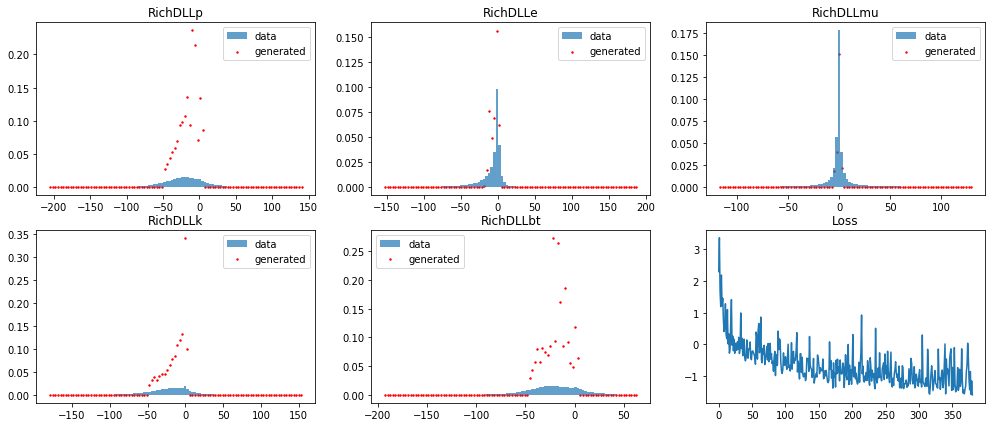

KeyboardInterrupt: 

In [187]:
epoches = 501

for epoch in range(len(metrics), epoches):
    model.train()
    for step, (cond_x, batch_x) in zip(range(len(X_train) // 8192), data_gen):
        optimizer.zero_grad()
        z, logp_z, log_det = model(batch_x, cond_x)
        logp_x = logp_z + log_det
        loss = -torch.mean(logp_x)
        loss.backward()
        optimizer.step()
    metrics.append(loss.mean().detach())

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            Y_test = np.random.uniform(-1, 1, (100000, dim)).astype('float32')
            Y_test_ = preprocessor.q_scaler.inverse_transform(Y_test)
            idxs = neigh.kneighbors(Y_test_, 1, return_distance=False)[:, 0]
            X_test = X_val[idxs]

            z, logp_z, log_det = model(
                torch.from_numpy(Y_test).to(device),
                torch.from_numpy(X_test).to(device)
            )
            log_probs = logp_z + log_det
            log_probs = log_probs.cpu().numpy()

            clear_output(False)
            fig, axs = plt.subplots(2, 3, figsize=(17, 7))
            for i in range(dim):
                _, bins, _ = axs[i // 3, i % 3].hist(Y_val_[:, i], 100, label="data", density=True, alpha=0.7)
                axs[i // 3, i % 3].scatter(*bin_log_probs(Y_test_[:, i], log_probs, bins), label="generated", c='red', s=2)
                axs[i // 3, i % 3].set_title(dlls[i])
                axs[i // 3, i % 3].legend()
            axs[1, 2].plot(np.arange(len(metrics)), metrics)
            axs[1, 2].set_title('Loss')
        plt.show()

In [188]:
metrics[-10:]

[tensor(-1.5986, device='cuda:0'),
 tensor(-0.7339, device='cuda:0'),
 tensor(-0.6920, device='cuda:0'),
 tensor(-0.9885, device='cuda:0'),
 tensor(-0.8115, device='cuda:0'),
 tensor(-0.9717, device='cuda:0'),
 tensor(-0.6811, device='cuda:0'),
 tensor(-1.1444, device='cuda:0'),
 tensor(-1.3264, device='cuda:0'),
 tensor(-1.2148, device='cuda:0')]

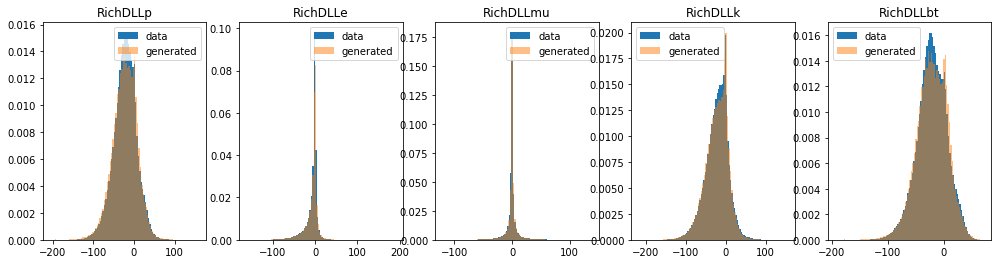

In [189]:
model.eval()
with torch.no_grad():
    Z_test = np.random.normal(0, 1, (len(X_val), dim)).astype('float32')
    Y_pred, log_det = model.backward(
        torch.from_numpy(Z_test).to(device),
        torch.from_numpy(X_val).to(device)
    )
    Y_pred = Y_pred.cpu().numpy()
    Y_pred = preprocessor.q_scaler.inverse_transform(Y_pred)
    
    fig, axs = plt.subplots(1, dim, figsize=(17, 4))
    for i in range(dim):
        axs[i].hist(Y_val_[:, i], 100, label="data", density=True)
        axs[i].hist(Y_pred[:, i], 100, label="generated", density=True, alpha=0.5)
        axs[i].legend()
        axs[i].set_title(dlls[i])

In [190]:
d1 = pd.DataFrame(np.hstack([Y_val_, X_val_, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([Y_pred, X_val_, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsGenerated'] = False
d2['IsGenerated'] = True
d2.head()

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsGenerated
0,9.642277,-19.002371,-7.581772,9.987966,9.854032,7242.500000,2.47509,213.0,-0.323443,True
1,-5.856104,-1.400353,-0.906325,16.142191,6.190442,65625.398438,3.81829,305.0,-0.400124,True
2,-74.098770,-1.129297,0.673173,-78.475037,-64.184517,24157.900391,3.62639,111.0,-0.388222,True
3,-5.220953,-0.017806,0.036724,-11.615635,-3.744574,30441.000000,3.62534,94.0,1.242800,True
4,-23.788099,-62.943729,-27.840593,-23.962088,-23.869007,4517.830078,3.15994,138.0,-0.335552,True


In [191]:
def plot_joint_dll_distributions(data, dlls):
    fig, axs = plt.subplots(len(dlls), len(dlls), figsize=(17, 15))#, sharex=True, sharey=True)

    for j, dll1 in enumerate(dlls):
        for i, dll2 in enumerate(dlls):
            q1_1, q1_99 = data[dll1].quantile(0.03), data[dll1].quantile(0.97)
            q2_1, q2_99 = data[dll2].quantile(0.03), data[dll2].quantile(0.97)

            if i == j:
                arr = data[[dll1]].query(f'{q1_1} < {dll1} < {q1_99}')
                axs[i, i].hist(arr[dll1], 100)
                axs[i, i].set_title(dll1)
            else:
                arr = data[[dll1, dll2]] \
                    .query(f'{q1_1} < {dll1} < {q1_99}') \
                    .query(f'{q2_1} < {dll2} < {q2_99}')

                axs[i, j].hist2d(arr[dll1], arr[dll2], (100, 100, ))
                m1, m2 = max(q1_1, q2_1), min(q1_99, q2_99)
                axs[i, j].plot(np.arange(m1, m2, 1), np.arange(m1, m2, 1), c='red')
                axs[i, j].set_title(dll1 + ' ' + dll2)

## Original data distributions

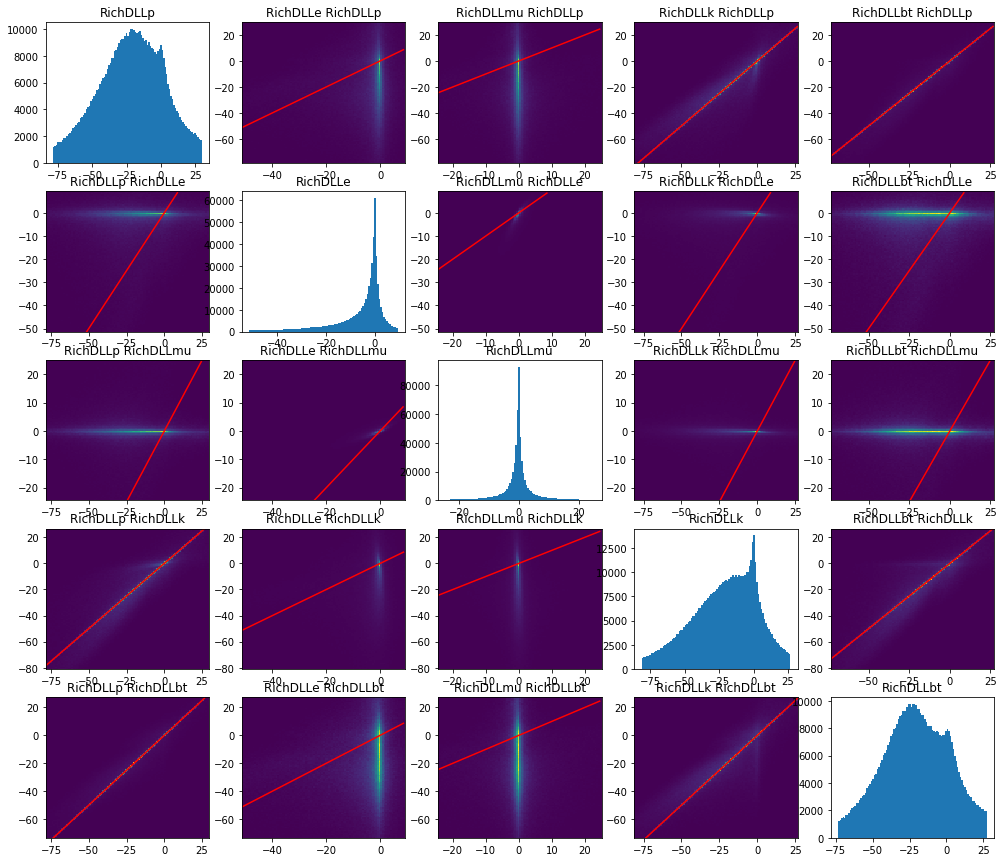

In [192]:
plot_joint_dll_distributions(d1, dlls)

## Generated data distributions

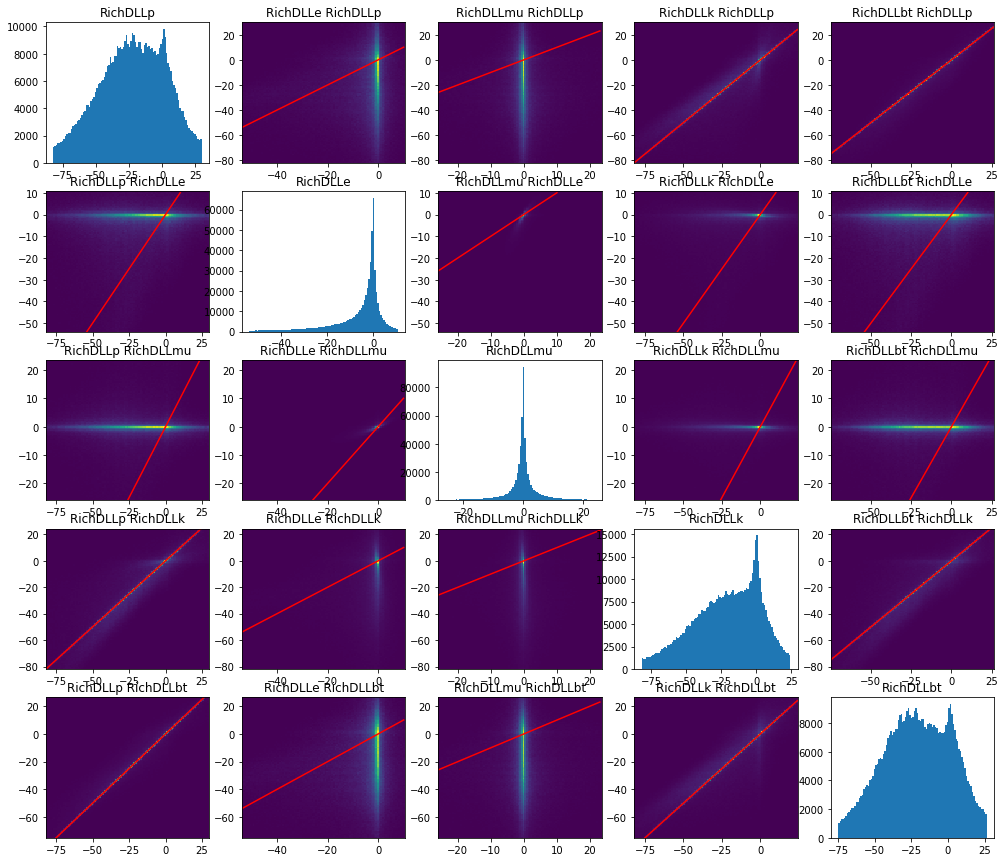

In [193]:
plot_joint_dll_distributions(d2, dlls)

In [194]:
def plot_joint_cond_dll_distributions(data, dll, features):
    fig, axs = plt.subplots(len(dlls) + 1, len(features), figsize=(17, 17))

    for j, f in enumerate(features):
        for i, dll in enumerate([None] + dlls):
            q2_1, q2_99 = data[f].quantile(0.03), data[f].quantile(0.97)
            if i == 0:
                arr = data[[f]].query(f'{q2_1} < {f} < {q2_99}')
                axs[i, j].hist(arr[f], 500)
                axs[i, j].set_title(f)
            else:
                q1_1, q1_99 = data[dll].quantile(0.03), data[dll].quantile(0.97)        

                arr = data[[dll, f]] \
                    .query(f'{q1_1} < {dll} < {q1_99}') \
                    .query(f'{q2_1} < {f} < {q2_99}')

                axs[i, j].hist2d(arr[f], arr[dll], (100, 100, ))
                axs[i, j].set_title(f + ' ' + dll)

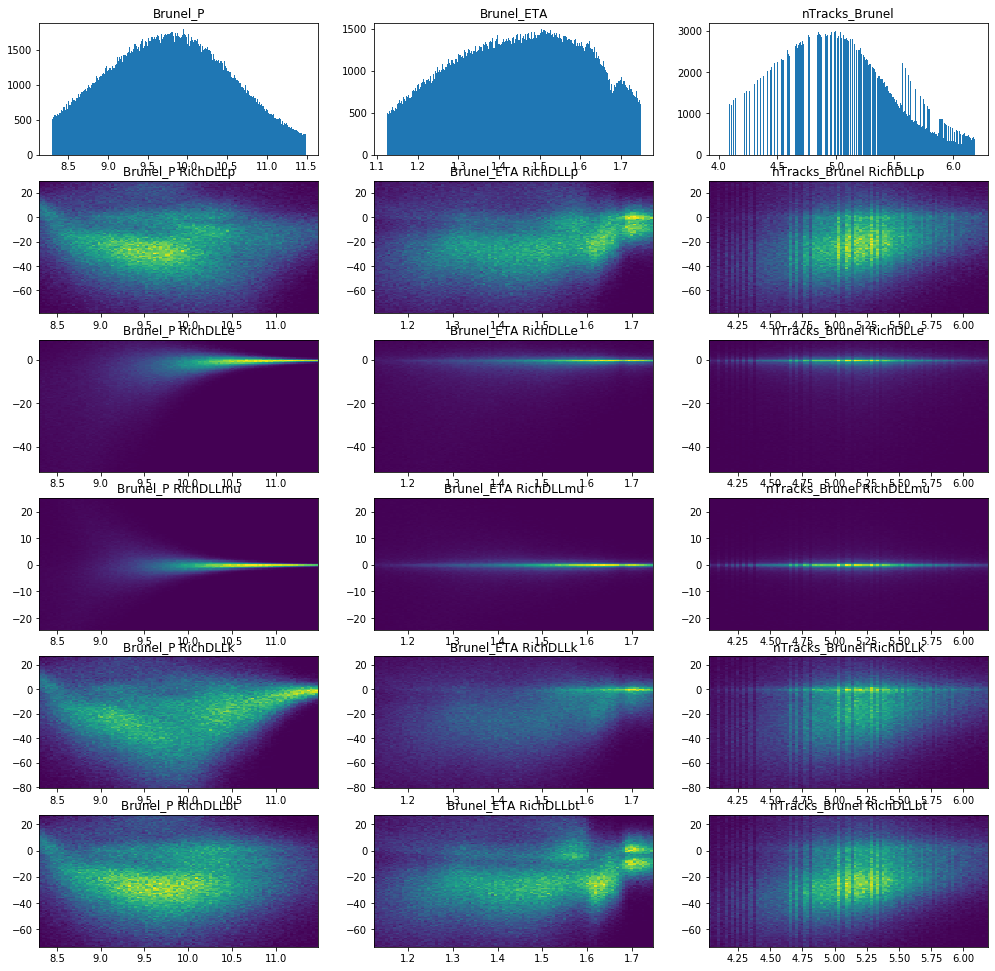

In [195]:
d1_ = d1.copy()
d1_[features] = np.log(d1_[features] + 1)
plot_joint_cond_dll_distributions(d1_, dlls, features)

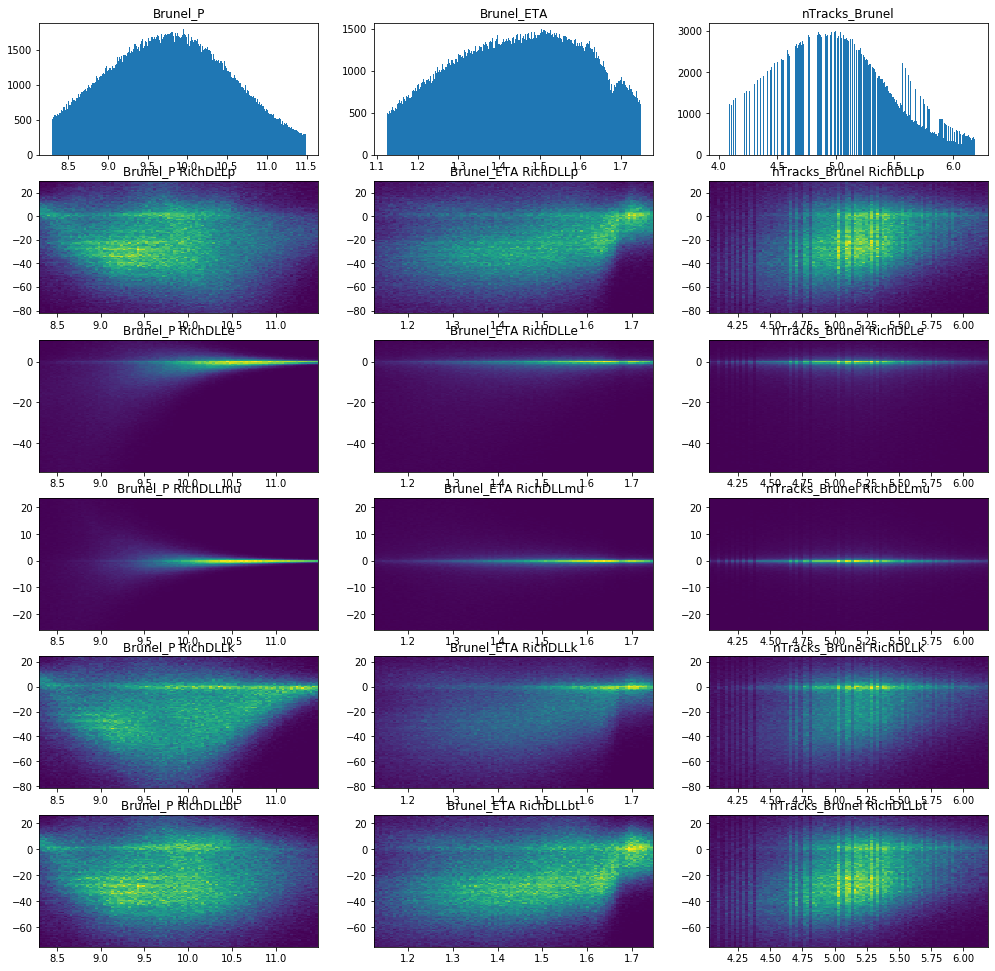

In [196]:
d2_ = d2.copy()
d2_[features] = np.log(d2_[features] + 1)
plot_joint_cond_dll_distributions(d2_, dlls, features)

In [197]:
n = d1.shape[0]
classification_ds = pd.concat([d1[: n // 2], d2[n // 2: ]]).sample(frac=1)
classification_ds.head(10)

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsGenerated
575366,56.330666,-0.454997,-0.502473,5.108007,7.644707,39131.199219,4.20121,316.0,0.682492,True
54079,-9.231730,-1.796470,-0.809954,-11.978700,-9.083340,30005.800781,4.15201,58.0,0.965608,False
139656,-35.548698,-13.864400,-0.920545,-27.916901,-35.548698,14141.900391,4.03000,167.0,-0.211712,False
457553,-7.996781,-1.870549,0.420253,-4.203732,-8.066208,21734.699219,4.75165,432.0,-0.316678,True
171039,-11.742300,-1.288770,-0.183962,-10.692700,-12.762300,18278.800781,4.10831,138.0,-0.382962,False
590491,-6.617934,-0.820651,-0.475113,-8.713186,-18.912407,48523.601562,4.31557,250.0,0.902333,True
447509,-56.278015,-1.140144,-0.999407,-23.977440,-45.190258,24253.900391,2.45829,173.0,0.679932,True
362076,17.418959,11.552012,5.905377,16.956730,17.044678,5107.580078,3.44533,190.0,0.309043,True
591659,-37.796436,0.249909,0.111854,-8.795004,-22.235817,106113.000000,4.20447,220.0,0.164742,True
55160,-15.159300,-11.335500,-7.581490,-14.496200,-15.159300,9644.089844,3.87237,351.0,0.856921,False


In [198]:
n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]
cls_train.shape, cls_val.shape

((416684, 10), (178579, 10))

In [199]:
from rich_utils.my_roc_auc import my_roc_auc

In [200]:
import xgboost as xgb

In [201]:
params = dict(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    min_child_weight=50,
    n_jobs=24
)
xgb_model = xgb.XGBClassifier(**params)

In [202]:
xgb_model.fit(
    X=cls_train[dlls + features].values,
    y=cls_train['IsGenerated'].values.astype('int32'),
    sample_weight=cls_train[weight_filed]
)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=None, n_estimators=200, n_jobs=24,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [203]:
is_gen_pred = xgb_model.predict(cls_val[dlls + features].values)
is_gen_true = cls_val['IsGenerated'].values
cls_weights = cls_val[weight_filed].values

In [207]:
np.sum(is_gen_pred == is_gen_true) / len(is_gen_pred)

0.5551156630958848

In [208]:
from sklearn.metrics import roc_auc_score

In [209]:
is_gen_pred_probas = xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1]
roc_auc_score(is_gen_true, is_gen_pred_probas)

0.5802855439004067

In [210]:
my_roc_auc(is_gen_true, xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1], cls_weights)

0.7320987956928503